# Ứng dụng shap cho Survival analysis

## BS. Lê Ngọc Khả Nhi

# Giới thiệu

Cách đây 2 ngày có một thành viên trong nhóm đặt ra câu hỏi về một nghiên cứu genomic với mục tiêu xác định tổ hợp k gene quan trọng nhất cho mục tiêu tiên lượng tử vong trong bệnh ung thư phổi. Theo nội dung bài báo thì các tác giả đã sử dụng phương pháp chọn lọc biến số dựa vào nhiều mô hình Cox-PH survival đa biến. 

### Bài thực hành này nhằm 3 mục tiêu:

1) Tái hiện lại kỹ thuật chọn lọc tổ hợp gene tiên lượng tử vong bằng mô hình hồi quy Cox trên 1 bộ dữ liệu tương tự

2) Giải đáp câu hỏi cho bạn đồng nghiệp : tại sao tác giả chọn k = 16 chưa không phải một con số nào khác ?

3) Thử áp dụng phương pháp diễn giải mô hình SHAP như giải pháp thay thế cho bài toán này, thông qua mô hình XGboost Cox Survival

# Dữ liệu

Nhi sử dụng bộ dữ liệu lungcancer_shedden của tác giả Kerby Shedden và cộng sự trên thư viện OpenML, dựa trên bài báo đăng trên tờ Nature Medicine năm 2008.

Dữ liệu này có cấu trúc điển hình cho bài toán Survival analysis, nó gồm 442 bệnh nhân, 1 cột OS_event chỉ biến cố tử vong (gồm 236 trường hợp tử vong, 206 censored), OS_years chỉ thời gian đến lúc biến cố tử vong tính bằng năm, tuổi, giới tính, và biểu hiện của 19 genes.

'https://www.openml.org/data/get_csv/552598/phpl04K8a.csv'

In [236]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

from sksurv.linear_model import CoxPHSurvivalAnalysis

import xgboost
from lifelines import KaplanMeierFitter

# SHAP
import shap
shap.initjs()

# Chuẩn bị dữ liệu

In [2]:
df = pd.read_csv('https://www.openml.org/data/get_csv/552598/phpl04K8a.csv').drop(['histology'], axis = 1)

df['OS_event'] = df['OS_event'].map({"'1'":1, "'0'":0})
df['sex'] = df['sex'].map({"'m'":1, "'f'":0})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   OS_years                     442 non-null    float64
 1   OS_event                     442 non-null    int64  
 2   age                          442 non-null    int64  
 3   sex                          442 non-null    int64  
 4   g_202387_at                  442 non-null    float64
 5   g_211475_s_at                442 non-null    float64
 6   g_204531_s_at                442 non-null    float64
 7   g_211851_x_at                442 non-null    float64
 8   g_203967_at                  442 non-null    float64
 9   g_203968_s_at                442 non-null    float64
 10  g_201938_at                  442 non-null    float64
 11  g_202454_s_at                442 non-null    float64
 12  g_215638_at                  442 non-null    float64
 13  g_214088_s_at       

In [213]:
# Thí dụ 1 trường hợp trong dataframe

df.loc[0]

OS_years                        1.333333
OS_event                        1.000000
age                            64.000000
sex                             1.000000
g_202387_at                     8.531719
g_211475_s_at                   8.617078
g_204531_s_at                   6.679836
g_211851_x_at                   7.319134
g_203967_at                     5.896348
g_203968_s_at                   6.289116
g_201938_at                    11.676581
g_202454_s_at                   9.561092
g_215638_at                     6.084346
g_214088_s_at                   8.697247
g_216010_x_at                   6.687298
g_206924_at                     5.287486
g_206926_s_at                   7.504454
g_204890_s_at                   7.130403
g_204891_s_at                   7.482673
g_212724_at                     9.569744
g_204979_s_at                   6.331134
g_AFFX.HUMGAPDH.M33197_5_at    13.631622
g_AFFX.HUMGAPDH.M33197_M_at    14.010980
Name: 0, dtype: float64

# Thăm dò dữ liệu

### Tần suất tử vong

In [49]:
df.OS_event.value_counts()

1    236
0    206
Name: OS_event, dtype: int64

### Thời gian sống còn

In [53]:
def survival_bar(df, event_col = 'OS_event', time_col = 'OS_years', event = 1, col = 'red'):
    df_sort = df.sort_values([time_col])
    df_event = df_sort[df_sort[event_col] == event]
    
    idx_1 = [str(i) for i in df_event.index]
    
    st_1 = [v for v in df_event[time_col]]
    
    plt.rcParams['figure.figsize'] = [20,5]
    plt.rcParams['figure.dpi']= 100
    
    x_1 = np.arange(len(idx_1))
    width = 0.3
    
    fig, ax = plt.subplots()
    ax.bar(x_1 - width/2, st_1, width, label = event, color = col)
    
    ax.set_ylabel('Survival time')
    ax.legend()

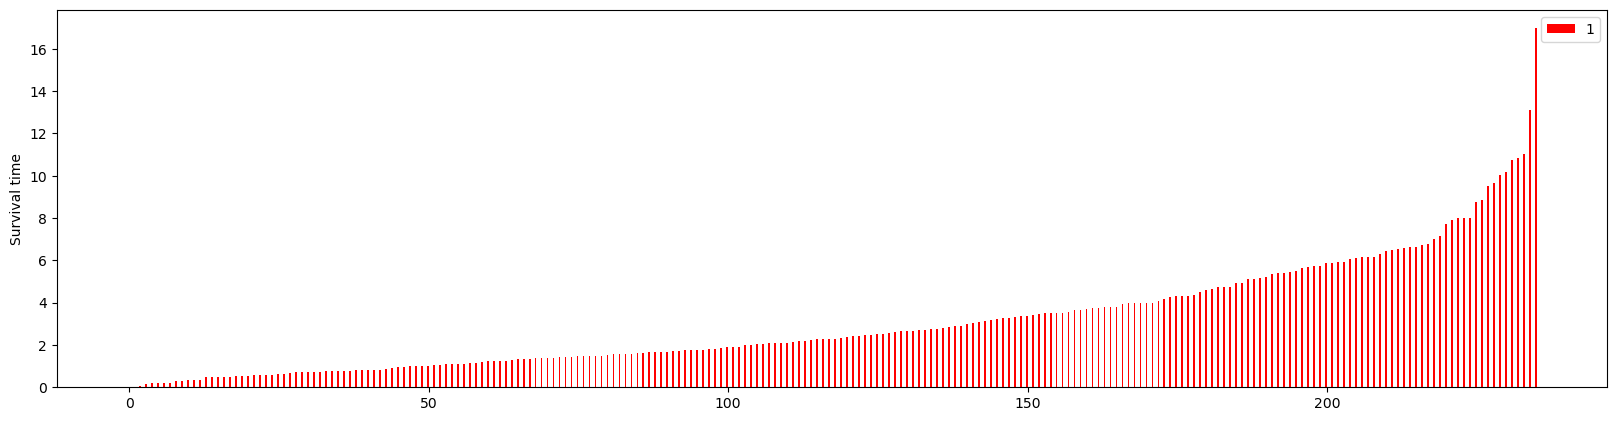

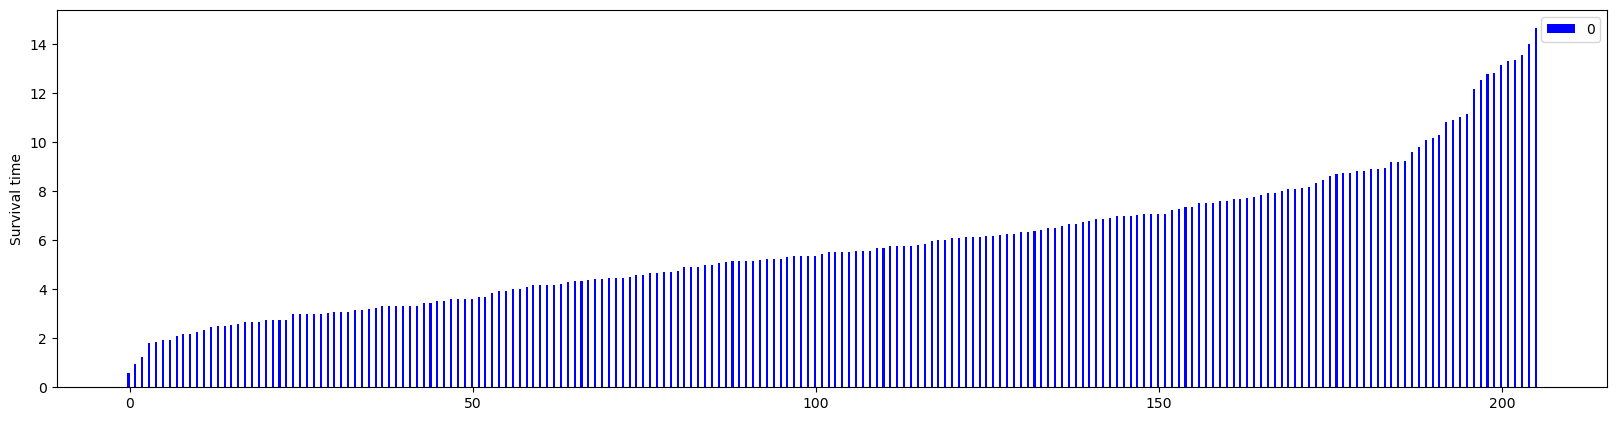

In [55]:
survival_bar(df, event_col = 'OS_event', time_col = 'OS_years', event = 1, col = 'red')
survival_bar(df, event_col = 'OS_event', time_col = 'OS_years', event = 0, col = 'blue')

### Biểu hiện 19 gene giữa 2 phân nhóm

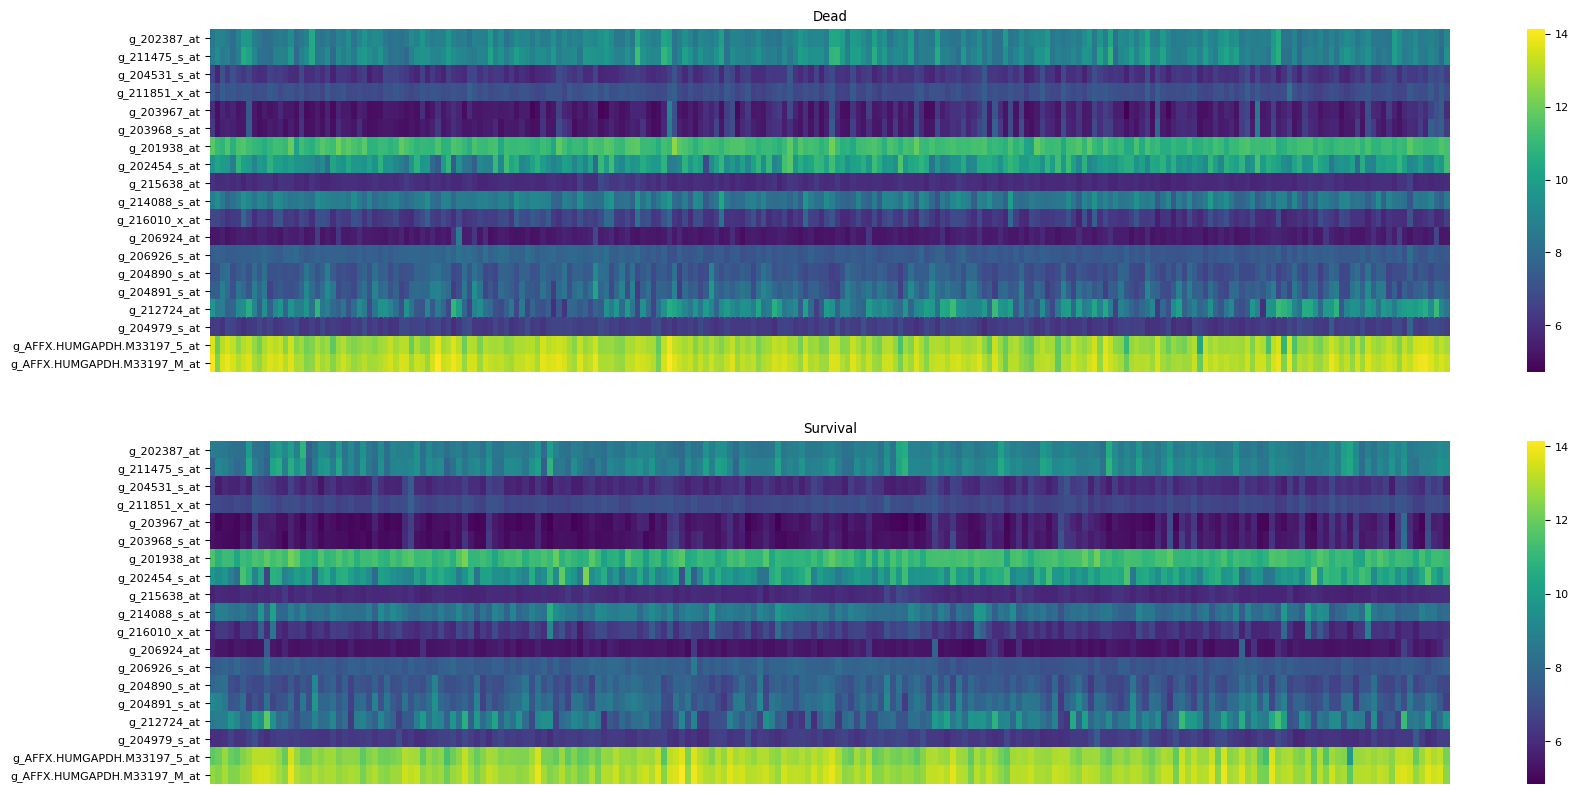

In [215]:
hm_df = df.drop(['OS_years', 'OS_event','sex','age'], axis = 1)

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].set_title('Dead')
ax[1].set_title('Survival')
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)
sns.heatmap(hm_df[df['OS_event'] == 1].T, ax = ax[0], cmap=cm.viridis,)
sns.heatmap(hm_df[df['OS_event'] != 1].T, ax = ax[1], cmap=cm.viridis)

### Phân bố của 20 features trong 2 phân nhóm

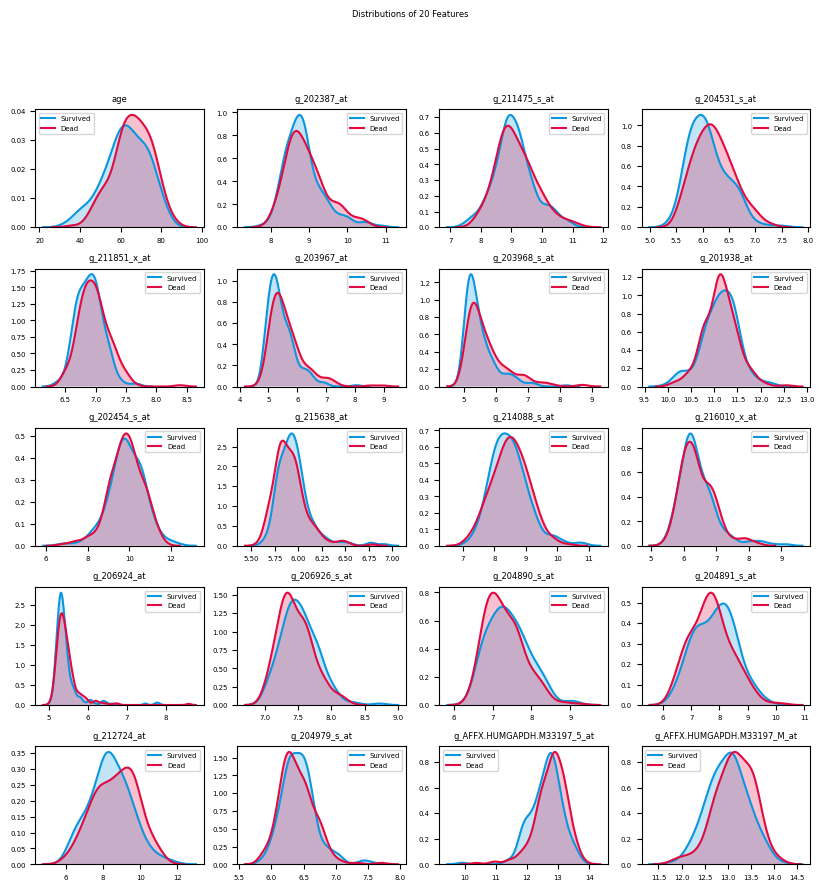

In [226]:
plot_df = df.drop(['OS_years','sex'], axis = 1)
feat_names = list(plot_df.drop(['OS_event'], axis = 1).columns)
sns.set_palette(sns.color_palette(['#0b96e0','#e00b41']))
lab_dict = {1: 'Dead', 0:'Survived'}

plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams.update({'font.size': 5})

fig, axes = plt.subplots(nrows=5, ncols=4)
fig.subplots_adjust(hspace=0.35)
fig.suptitle('Distributions of 20 Features')

for ax,feature,name in zip(axes.flatten(), 
                           feat_names,
                           feat_names):
    ax.set(title=name)
    for i in [0,1]:
        sns.kdeplot(data = plot_df[plot_df['OS_event'] == i][feature].values,
                    label = lab_dict[i],
                    shade = True,
                    ax = ax)

# Mô hình hồi quy Cox đa biến

Đầu tiên, ta thử dựng 1 mô hình hồi quy Cox sử dụng toàn bộ 21 features

Nhi sử dụng pacakge scikit-survival mà các bạn có thể install dễ dàng từ : https://github.com/sebp/scikit-survival 

### Chuẩn bị dữ liệu cho mô hình

Chú ý : output của mô hình có dạng numpy array 1 chiều, mỗi phần tử là 1 tuple theo thứ tự: Giá trị logic của event =1 và thời gian, định dạng (Boolean, float) 

Dữ liệu đầu vào X là dataframe hay numpy array 2 chiều, Mỗi hàng là 1 trường hợp, cột là features

In [112]:
data_y= np.array([(e,t) for e,t in zip(df.OS_event == 1, df.OS_years)],
                 np.dtype('bool,float'))

data_X = df.drop(['OS_years', 'OS_event'], axis = 1)

In [228]:
data_y[:3]

array([( True, 1.33333333), (False, 6.        ), (False, 3.91666667)],
      dtype=[('f0', '?'), ('f1', '<f8')])

In [229]:
data_X[:3]

,age,sex,g_202387_at,g_211475_s_at,g_204531_s_at,g_211851_x_at,g_203967_at,g_203968_s_at,g_201938_at,g_202454_s_at,...,g_214088_s_at,g_216010_x_at,g_206924_at,g_206926_s_at,g_204890_s_at,g_204891_s_at,g_212724_at,g_204979_s_at,g_AFFX.HUMGAPDH.M33197_5_at,g_AFFX.HUMGAPDH.M33197_M_at
0,64,1,8.531719,8.617078,6.679836,7.319134,5.896348,6.289116,11.676581,9.561092,...,8.697247,6.687298,5.287486,7.504454,7.130403,7.482673,9.569744,6.331134,13.631622,14.010980
1,62,1,8.683686,7.684136,6.658628,6.940731,5.420231,5.300152,11.504114,9.799510,...,7.907645,5.848469,5.698212,7.466370,7.859878,9.190885,8.629740,6.134950,11.769316,12.639903
2,70,0,8.654110,9.120100,5.496528,6.884961,4.964120,5.149911,10.788714,9.277472,...,8.866053,6.314171,5.366511,7.575214,8.094832,8.962269,8.743071,6.149654,12.075454,12.431824


### Fit mô hình

In [113]:
estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_X, data_y)

CoxPHSurvivalAnalysis(alpha=0, n_iter=100, ties='breslow', tol=1e-09, verbose=0)

### Giá trị hệ số hồi quy cho 21 features

In [114]:
pd.Series(estimator.coef_, index= data_X.columns)

age                            0.031173
sex                            0.231185
g_202387_at                    1.123406
g_211475_s_at                 -0.640254
g_204531_s_at                 -0.491530
g_211851_x_at                  1.221203
g_203967_at                    0.019981
g_203968_s_at                  0.249900
g_201938_at                    0.072111
g_202454_s_at                 -0.166429
g_215638_at                   -1.362348
g_214088_s_at                  0.286746
g_216010_x_at                 -0.181411
g_206924_at                   -0.430236
g_206926_s_at                 -0.308601
g_204890_s_at                  0.519660
g_204891_s_at                 -0.430770
g_212724_at                    0.108201
g_204979_s_at                  0.184570
g_AFFX.HUMGAPDH.M33197_5_at    0.197915
g_AFFX.HUMGAPDH.M33197_M_at    0.241207
dtype: float64

Hàm predict survival function cho phép xuất ra kết quả là hàm survival, từ đó ta có thể vẽ biểu đồ tiên lượng xác suất sống còn theo thời gian trong khoảng 0-17 năm cho mỗi cá thể

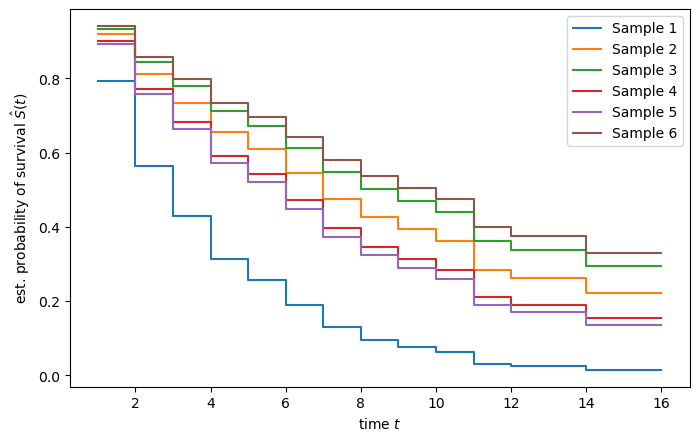

In [122]:
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['figure.dpi']= 100

pred_surv = estimator.predict_survival_function(data_X.loc[:5])
time_points = np.arange(1, 17)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

### Khảo sát phẩm chất mô hình bằng C-index

Ta có thể tính c-index (Còn gọi là C-statistic) bằng 2 cách:

Giá trị tốt nhất của C-index = 1, Hiện thời mô hình Cox đa biến của chúng ta có phẩm chất khá tốt với C-index = 0.68

In [139]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(data_X)
result = concordance_index_censored(df['OS_event'] == 1, # event
                                    df['OS_years'], # time
                                    prediction)
result[0]

0.6772776007610879

In [140]:
estimator.score(data_X, data_y)

0.6772776007610879

# Chọn lọc tập hợp features tối ưu

Đầu tiên, ta thử dựng 21 mô hình hồi quy Cox đơn biến cho mỗi feature, sau đó tính c-index tương ứng và xếp hạng theo giá trị c-index

In [141]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

Đây là kết quả xếp hạng c-index từ cao đến thấp cho 21 features

In [144]:
scores = fit_and_score_features(data_X.values, data_y)

pd.Series(scores, index=data_X.columns).sort_values(ascending=False)

g_203968_s_at                  0.612766
g_203967_at                    0.607708
g_AFFX.HUMGAPDH.M33197_M_at    0.599644
g_211851_x_at                  0.597424
g_AFFX.HUMGAPDH.M33197_5_at    0.596593
g_204531_s_at                  0.587669
age                            0.569917
g_212724_at                    0.563688
g_215638_at                    0.553510
sex                            0.541437
g_202454_s_at                  0.538892
g_202387_at                    0.537851
g_204891_s_at                  0.531327
g_204979_s_at                  0.525468
g_206926_s_at                  0.525075
g_204890_s_at                  0.524426
g_211475_s_at                  0.516437
g_201938_at                    0.515093
g_214088_s_at                  0.493756
g_216010_x_at                  0.492684
g_206924_at                    0.451005
dtype: float64

Bước tiếp theo, ta thực hiện một quy trình chọn lọc biến số bằng phương pháp Gridsearch + kiểm chứng chéo 5x5 

Quy trình này cho phép xếp hạng những tổ hợp features cho ra c-index tốt nhất trên tập kiểm định

In [145]:
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

pipe = Pipeline([('select', SelectKBest(fit_and_score_features, k=5)),
                 ('model', CoxPHSurvivalAnalysis())])

param_grid = {'select__k': np.arange(1, data_X.shape[1] + 1)}
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=5)
gcv.fit(data_X, data_y)

cv_df = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
cv_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
17,1.004522,0.049922,0.004189,0.005544,18,{'select__k': 18},0.575286,0.666067,0.691253,0.633971,...,0.632233,0.043108,1,0.686494,0.663056,0.667220,0.677245,0.696555,0.678114,0.012300
20,0.968673,0.057115,0.003541,0.006093,21,{'select__k': 21},0.575286,0.632313,0.679392,0.661996,...,0.628534,0.039422,2,0.691586,0.670156,0.666983,0.678074,0.694425,0.680245,0.011064
18,0.990798,0.083767,0.001397,0.001192,19,{'select__k': 19},0.564901,0.669667,0.674574,0.636705,...,0.628207,0.042518,3,0.686051,0.661485,0.668476,0.676782,0.696631,0.677885,0.012465
14,0.991226,0.114088,0.003667,0.003706,15,{'select__k': 15},0.576843,0.653015,0.691994,0.626794,...,0.624797,0.044859,4,0.682908,0.659255,0.663783,0.678342,0.688971,0.674652,0.011331
19,0.946570,0.066868,0.000425,0.000850,20,{'select__k': 20},0.565940,0.673267,0.661972,0.634997,...,0.624408,0.041987,5,0.690014,0.661918,0.666983,0.677781,0.695465,0.678432,0.012872
15,1.063006,0.180232,0.002710,0.003485,16,{'select__k': 16},0.578920,0.644914,0.689400,0.623377,...,0.623653,0.041327,6,0.685343,0.657184,0.664755,0.677001,0.689098,0.674676,0.012096
16,0.955600,0.075803,0.006774,0.005458,17,{'select__k': 17},0.579958,0.652565,0.685693,0.624402,...,0.622509,0.043531,7,0.683793,0.662509,0.664542,0.677099,0.692852,0.676159,0.011481
13,1.131761,0.089954,0.001625,0.003251,14,{'select__k': 14},0.569574,0.644914,0.694589,0.627820,...,0.622387,0.046435,8,0.686295,0.657366,0.664921,0.678634,0.688413,0.675126,0.012109
12,0.932376,0.054681,0.003939,0.002290,13,{'select__k': 13},0.564901,0.651665,0.686805,0.627478,...,0.621298,0.045862,9,0.685454,0.654840,0.664968,0.679122,0.688236,0.674524,0.012707
11,0.844439,0.055824,0.000423,0.000846,12,{'select__k': 12},0.556075,0.644014,0.677910,0.628161,...,0.616961,0.044152,10,0.675603,0.654612,0.663475,0.678342,0.688286,0.672064,0.011777


Theo kết quả xếp hạng, mô hình có hiệu năng tối ưu cần dùng 18/21 features

Text(0, 0.5, ' c-index score')

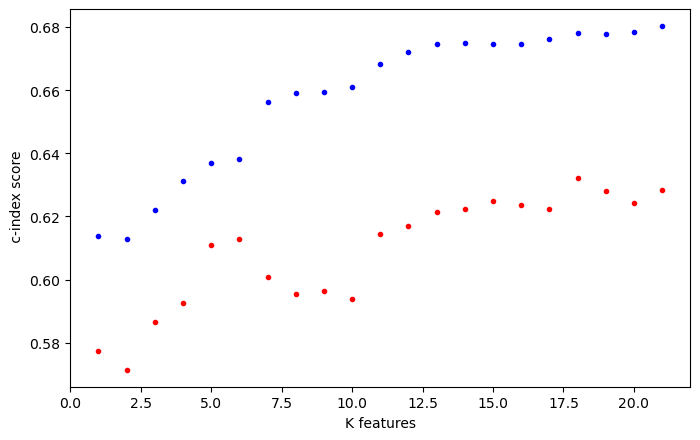

In [167]:
fig, ax = plt.subplots()
ax.plot(cv_df.param_select__k, cv_df.mean_train_score,'.b', label = 'Train')
ax.plot(cv_df.param_select__k, cv_df.mean_test_score,'.r', label = 'Test')
plt.xlabel("K features")
plt.ylabel(' c-index score')

Ta dựng mô hình với 18 features này, đây là kết quả

In [174]:
gcv.best_params_

{'select__k': 18}

In [176]:
pipe.set_params(**gcv.best_params_)
pipe.fit(data_X, data_y)

transformer, final_estimator = [s[1] for s in pipe.steps]

In [316]:
final_estimator.score(data_X[data_X.columns[transformer.get_support()]], data_y)

0.6781232539526736

Đây là tên của 18 features quan trọng nhất mà ta tìm được:

In [182]:
pd.Series(final_estimator.coef_, index=data_X.columns[transformer.get_support()])

age                            0.028906
sex                            0.247538
g_202387_at                    1.032122
g_211475_s_at                 -0.597380
g_204531_s_at                 -0.546812
g_211851_x_at                  1.304321
g_203967_at                   -0.097198
g_203968_s_at                  0.243951
g_201938_at                    0.054050
g_202454_s_at                 -0.158287
g_215638_at                   -1.432601
g_206926_s_at                 -0.646133
g_204890_s_at                  0.467396
g_204891_s_at                 -0.429914
g_212724_at                    0.067674
g_204979_s_at                  0.152275
g_AFFX.HUMGAPDH.M33197_5_at    0.007091
g_AFFX.HUMGAPDH.M33197_M_at    0.439245
dtype: float64

# XGBoost Survival + SHAP

Trong phần tiếp theo, Nhi sẽ sẽ thử nghiệm một cách làm khác thay thế cho mô hình hồi quy Cox, đó là kết hợp 1 mô hình Xgboost survival và kỹ thuật diễn giải SHAP

### Chuẩn bị dữ liệu cho mô hình XGboost survival

Mô hình XGboost có hỗ trợ mục tiêu phân tích Survival, mô hình này nhận dữ liệu đầu vào là 1 dataframe hay numpy 2D array X, và 1 array Y chỉ thời gian theo dõi đến khi 1 biến cố phát sinh.

In [230]:
y = df['OS_years']
X = df.drop(['OS_years', 'OS_event'], axis = 1)
xgb_full = xgboost.DMatrix(data_X, label=y)

### Dựng mô hình trên toàn bộ dataframe X

In [231]:
params = {'objective': 'survival:cox',
          'learning_rate': 0.002,
          'gamma': 0.001,
          'max_depth': 10,
          'subsample': 0.5,
          'tree_method':'gpu_hist',
          'booster':'gbtree',
          'predictor':'gpu_predictor'
         }

In [232]:
model = xgboost.train(params, xgb_full, 2100,
                      evals = [(xgb_full, "test")],
                      verbose_eval=300)

[0]	test-cox-nloglik:5.10189
[300]	test-cox-nloglik:4.89728
[600]	test-cox-nloglik:4.74670
[900]	test-cox-nloglik:4.62154
[1200]	test-cox-nloglik:4.51951
[1500]	test-cox-nloglik:4.43010
[1800]	test-cox-nloglik:4.35212
[2099]	test-cox-nloglik:4.28312


### Kiểm tra trực quan kết quả mô hình

Ta có thể dùng biểu đồ Kaplan-Meier để so sánh kết quả của mô hình XGboost survival và dữ liệu quan sát thực tế.

Kết quả cho thấy mô hình dự báo khá tốt xác suất sống còn của các bệnh nhân:

Text(0.5, 0, 'Thời gian (năm)')

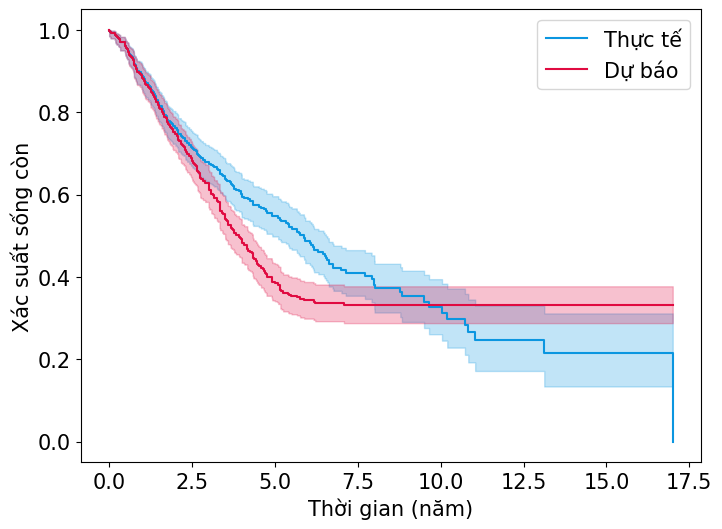

In [239]:
T = df['OS_years']
E_truth =  df['OS_event']
E_pred =  model.predict(xgb_full)

plt.rcParams['figure.figsize'] = [8,6]
plt.rcParams['figure.dpi']= 100

kmf = KaplanMeierFitter()

plt.rcParams.update({'font.size': 15})
ax = plt.subplot(111)
ax = kmf.fit(T, E_truth, label="Thực tế").plot(ax=ax)
ax = kmf.fit(T, E_pred, label="Dự báo").plot(ax=ax)
plt.ylabel("Xác suất sống còn")
plt.xlabel("Thời gian (năm)")

### Tính chỉ số c-index cho mô hình

Mô hình XGboost survival có kết quả c-index rất cao là 0.95

In [240]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

c_statistic_harrell(model.predict(xgb_full, ntree_limit=2100), y)

0.9559469101152475

### Diễn giải bằng SHAP

Do mục tiêu của thí nghiệm không phải là mô hình tiên lượng, mà là xác định tập hợp những features (gene) quan trọng nhất dễn đến kết quả tiên lượng này, Nhi sẽ thử áp dụng kỹ thuật diễn giải mô hình Shap

Như thường lệ, ta tạo ra 1 explainer object, rồi áp dụng cho mô hình Xgboost đã có, sau đó trích xuất giá trị shap score trong object shap_values

In [241]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

Dựa vào shap scores, ta có thể xếp hạng được những features (bao gồm các gene) có đóng góp quan trọng nhất và việc tiên lượng thời gian sống còn:

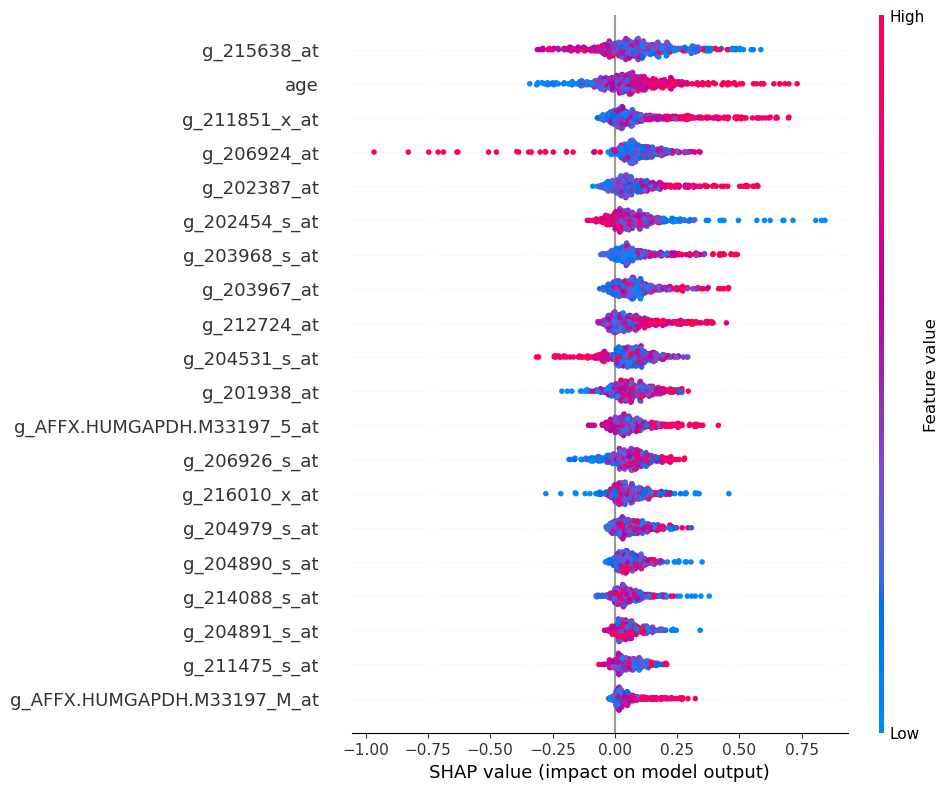

In [242]:
shap.summary_plot(shap_values,
                  X, 
                  feature_names = X.columns,
                  plot_type = "dot",
                  show = True,
                  sort = True,
                  auto_size_plot= True)

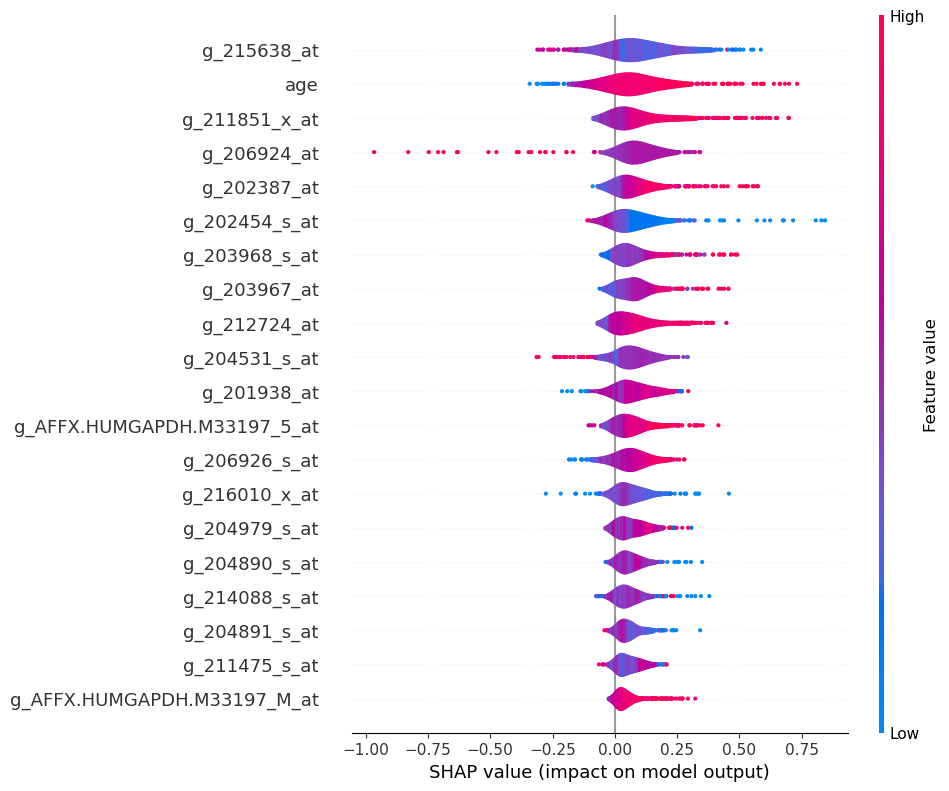

In [244]:
shap.summary_plot(shap_values,
                  X, 
                  feature_names = X.columns,
                  plot_type = "violin",
                  show = True,
                  sort = True,
                  auto_size_plot= True)

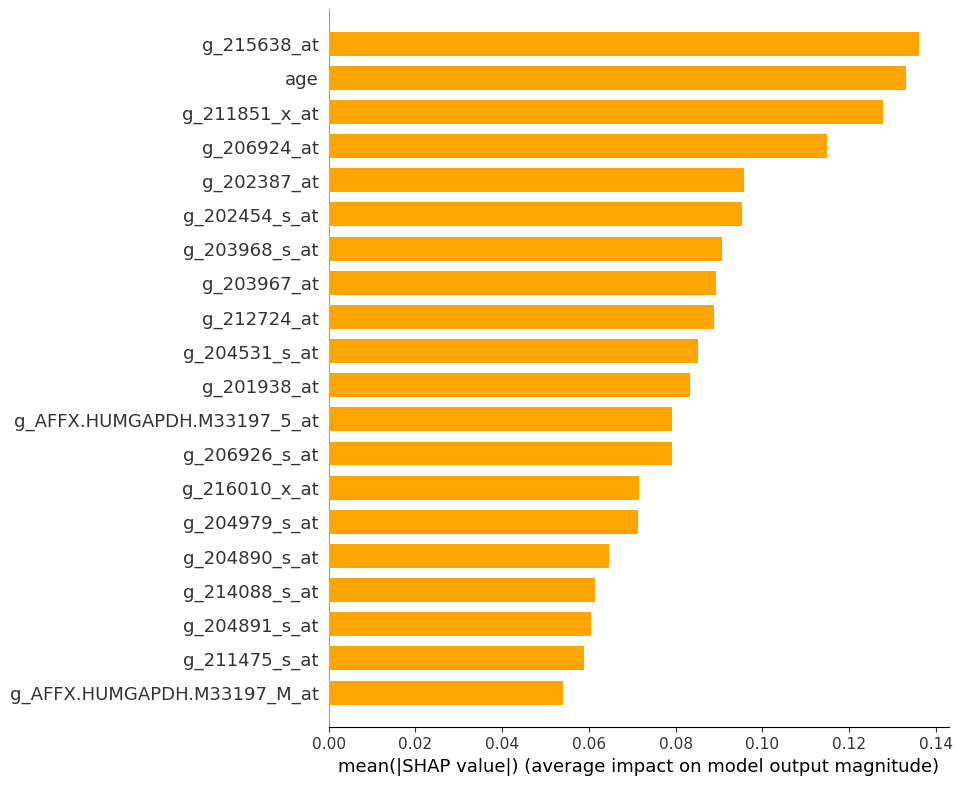

In [243]:
shap.summary_plot(shap_values, 
                  X, 
                  feature_names = X.columns,
                  plot_type = "bar",
                  color = 'orange',
                  show = True,
                  sort = True,
                  auto_size_plot= True)

### Sự hợp tác giữa các gene ?

Một ứng dụng khác rất thú vị của phương pháp shap, đó là ta có thể khảo sát được về sự hợp tác của các features trong mô hình Xgboost để dẫn đến kết quả tiên lượng sau cùng. Như ta biết, shap score của mỗi feature đo lường lượng thay đổi trung bình trên kết quả dự báo mà 1 đội đạt được, khi feature đó tham gia vào đội. Như vậy, 2 features hợp tác hiệu quả với nhau khi shap score của chúng tương quan thuận với nhau. 

Bài toán này gần giống như ma trận tương quan :

In [245]:
shap_interaction_values = explainer.shap_interaction_values(X)

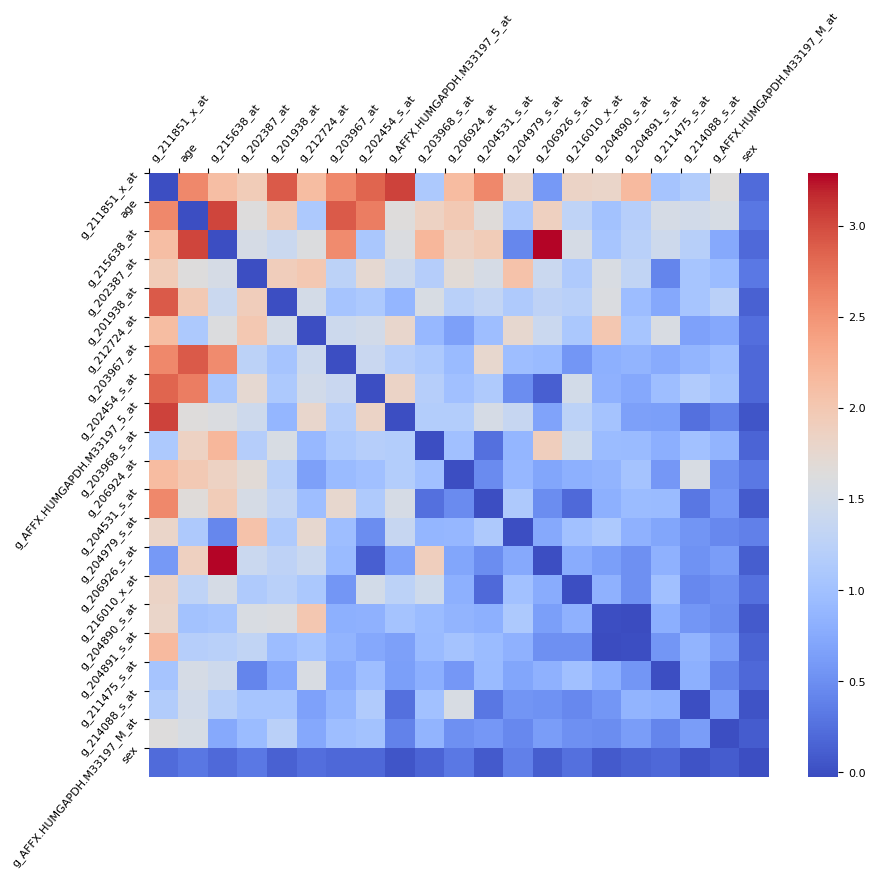

In [299]:
tmp = shap_interaction_values.sum(0)

for i in range(tmp.shape[0]):
    tmp[i,i] = 0

inds = np.argsort(-tmp.sum(0))
tmp2 = tmp[inds,:][:,inds]

plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 8})

sns.heatmap(tmp2, cmap = 'coolwarm')
plt.yticks(range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="right")
plt.xticks(range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="left")
plt.gca().xaxis.tick_top()

Ma trận « hợp tác » hơi khó đọc, nên Nhi sẽ chuyển ma trận này thành sơ đồ mạng (association network)

In [277]:
def correlation_network(corr = None, 
                        coefthres = 3.0, font_size = 5, width = 0.1):

    
    # 2) Lọc bỏ diagonal
    np.fill_diagonal(corr.values, 0)
    
    # 3) Lọc bỏ các edges theo ngưỡng
    corr[np.abs(corr) <= coefthres] = 0
    
    # 4) Chuyển adjacency sau khi làm sạch thành grasuph
    C = nx.from_pandas_adjacency(corr)
    
    # 5) Trích xuất weights (giá trị r của edges) và degrees (số liên kết đi đến 1 node)
    weights = np.array([d['weight'] for s,t,d in C.edges(data=True)])
    degrees = np.array([val for (node, val) in C.degree()])
    
    # 6) Vẽ graph
    pos = nx.kamada_kawai_layout(C)
    
    edges = nx.draw_networkx_edges(C,pos,
                                   edge_color=weights,
                                   width=width,
                                   edge_cmap=plt.cm.coolwarm)
    
    nodes = nx.draw_networkx(C, pos,
                             width=width,
                             edge_color=weights,
                             node_color=degrees,
                             cmap = plt.cm.YlOrRd,
                             edge_cmap=plt.cm.Reds,
                             node_size = 20*(degrees+5),
                             font_size = font_size,
                             )
    
    return C

In [313]:
for i in range(tmp.shape[0]):
    tmp[i,i] = 0

inds = np.argsort(-tmp.sum(0))
tmp2 = tmp[inds,:][:,inds]

tmp3 = pd.DataFrame(tmp2, columns=X.columns[inds], index = X.columns[inds])

plt.rcParams.update({
    'figure.figsize': (10,10),
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False})

np.random.seed(333)

import networkx as nx

Nếu đặt ra 1 ngưỡng cho mức độ hợp tác, thí dụ 1/3, ta có thể vẽ sơ đồ mạng lưới hợp tác của các gene trong mô hình XGboost;

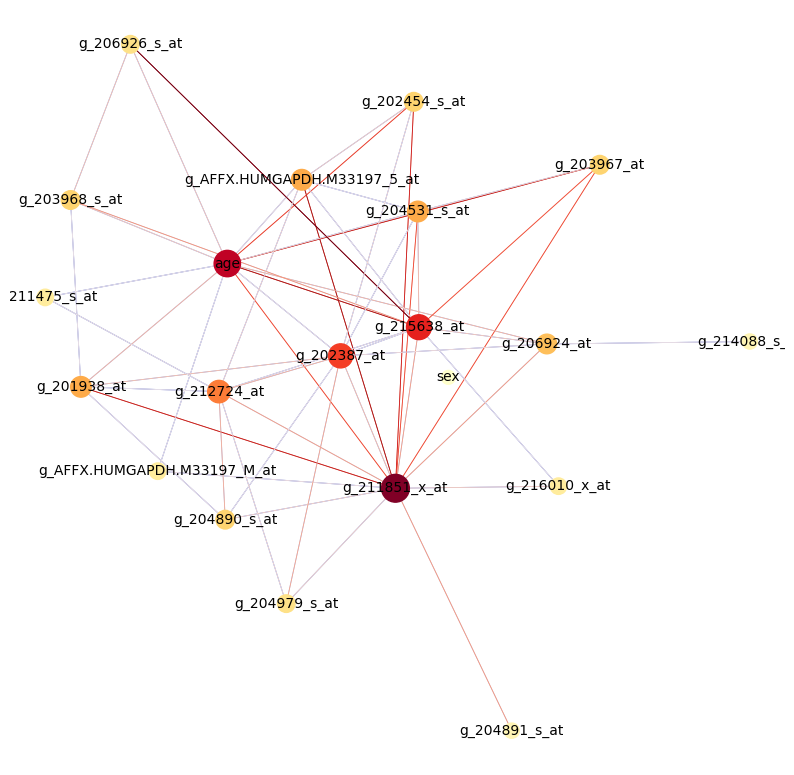

In [314]:
C = correlation_network(corr = tmp3,
                        coefthres = 1.5,
                        font_size = 10,
                        width = 0.6)

# Nhận xét :

Mô hình XGboost có cơ chế hoàn toàn khác với mô hình hồi quy Cox tuyến tính, do đó chúng có thể cho ra kết quả khác nhau về tổ hợp các gene quan trọng. Dù sao, shap là một giải pháp thay thế thú vị cho bài toán này. 